In [3]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 55.0 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve

video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / 'basketball.mp4'
vs = urlretrieve(video_url, video_path)
vs

(PosixPath('/tmp/tmpibcmrbzo/basketball.mp4'),
 <http.client.HTTPMessage at 0x7ae15e3ec890>)

In [3]:
from torchvision.io import read_video

frames, _, _ = read_video(str(video_path))

/usr/local/lib/python3.11/dist-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [4]:
frames = frames.permute(0, 3, 1, 2)
print(frames.shape)

torch.Size([333, 3, 720, 1280])


In [8]:
plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            # ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

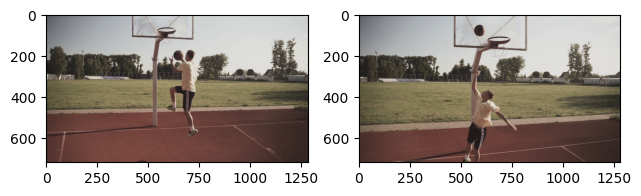

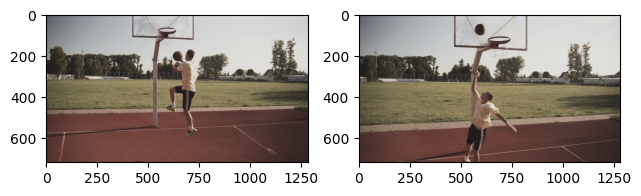

In [11]:
##
img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)
plot(img2_batch)

In [17]:
def preprocess(batch):
  transform = T.Compose(
      [
          T.ConvertImageDtype(torch.float32),
          T.Normalize(0.5, 0.5),
          T.Resize((520, 960)),
      ]
  )
  batch = transform(batch)
  return batch

In [18]:
## Preprocessing

img1_batch = preprocess(img1_batch).to(device) # gpu
img2_batch = preprocess(img2_batch).to(device) # gpu

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [19]:
# RAFT 모델 import
from torchvision import models

weights = models.optical_flow.Raft_Large_Weights
model = models.optical_flow.raft_large(weights=weights).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth
100%|██████████| 20.1M/20.1M [00:00<00:00, 226MB/s]


RAFT(
  (feature_encoder): FeatureEncoder(
    (convnormrelu): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (convnormrelu1): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu2): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (downsample): Identity()
        (relu): ReLU(inplace=True)
      )
      (1): ResidualBlock(
        (

In [20]:
list_of_flows = model(img1_batch, img2_batch)
print(type(list_of_flows))
print(len(list_of_flows))

<class 'list'>
12


In [22]:
## model outputs
# list_of_flows[-1].shape
predicted_flows = list_of_flows[0]
predicted_flows

tensor([[[[ 1.1517e-01,  1.1657e-01,  1.1694e-01,  ...,  6.3105e-03,
            6.8351e-03,  7.6833e-03],
          [ 1.1506e-01,  1.1638e-01,  1.1698e-01,  ...,  6.5455e-03,
            7.3274e-03,  8.7342e-03],
          [ 1.1539e-01,  1.1649e-01,  1.1675e-01,  ...,  6.9276e-03,
            7.9113e-03,  9.7106e-03],
          ...,
          [-8.8858e-01, -8.8935e-01, -8.8823e-01,  ..., -5.3294e-01,
           -5.3219e-01, -5.3301e-01],
          [-8.8777e-01, -8.8709e-01, -8.8680e-01,  ..., -5.3418e-01,
           -5.3288e-01, -5.3411e-01],
          [-8.8663e-01, -8.8602e-01, -8.8441e-01,  ..., -5.3522e-01,
           -5.3623e-01, -5.3791e-01]],

         [[-2.0086e-01, -2.0092e-01, -2.0139e-01,  ..., -5.7991e-04,
           -3.3534e-04, -1.3407e-04],
          [-2.0143e-01, -2.0119e-01, -2.0134e-01,  ..., -6.0268e-04,
           -3.4931e-04, -2.1564e-04],
          [-2.0194e-01, -2.0146e-01, -2.0139e-01,  ..., -6.3720e-04,
           -3.9013e-04, -2.6021e-04],
          ...,
     

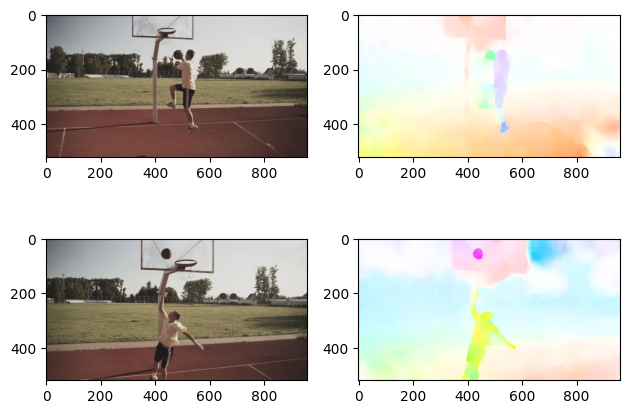

In [23]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)
img1_batch = [(img + 1) / 2 for img in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)